<a href="https://colab.research.google.com/github/stellacherotich/DFU-Image-Classification/blob/main/Diabetes_Foot_Ulcer_with_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diabetic Foot Ulcer Classification with Deep Learning**
___
## **Project Overview**
Diabetes is a chronic medical condition affecting blood sugar control.<br>There are two main types of diabetes:
  1. Type 1 Diabetes - linked to autoimmune factors
  2. Type 2 Diabetes - often associated with one's lifestyle. It is the most prevalent type out of the two.

Both of these types can result in complications such as heart disease, nerve impairment, and delayed wound healing.

**Diabetic Foot Ulcers**(DFUs) are a specific complication that can arise in people with diabetes. They are open sores or wounds that develop on the feet, most commonly on the bottom of the feet. DFUs are a result of multiple factors associated with diabetes, including poor circulation, nerve damage (neuropathy), and reduced immune function.

DFUs can become serious if left *untreated*. They have the potential to lead to infections that can spread to the bone or bloodstream, potentially resulting in the need for amputation.


### **Project Objectives**
---
The main objective of this project is:

- Build a machine learning model that will accurately identify whether a given image of a foot ulcer indicates a diabetic foot ulcer or not.


#### **Success Metrics**
The primary gauge of success was as follows:
- Accuracy: This metric represents the proportion of accurate classifications when identifying diabetic foot ulcers.
<br>The achievement target for accuracy was set at over 85%.

## **Data Overview**
The data was retrieved from [Kaggle](https://www.kaggle.com/datasets/laithjj/diabetic-foot-ulcer-dfu). This dataset contains a collection of images showcasing various stages of diabetic foot ulcers.
There are two main folders that were generated in order to carry out the classification, these include:

- Training - This was taken from the Patches folder

- Test - This was generated through converting the original Test Set folder, so that all the images were in a uniform format.

By leveraging this dataset and applying deep learning techniques, the project aims to contribute to the early and accurate detection of diabetic foot ulcers, ultimately assisting in timely medical interventions and reducing the risk of severe complications.


---
**⚠️ Kindly note that the DFU images are quite graphic. Viewer discretion is advised.**


### **Data Importation and Understanding**
At this stage of the CRISP-DM (Cross-Industry Standard Process for Data Mining) process, the necessary libraries are first imported to facilitate the subsequent data handling and analysis tasks. These libraries encompass  tools for data manipulation, numerical computations, visualization, and machine learning.


In [ ]:
# Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os

from google.colab import drive
from pylab import *

from PIL import Image


After setting up the required libraries, the next important task is loading the dataset. This is done by mounting the drive and specifying the directories for different data subsets: training, testing, and validation. The code in the cell below does just that, making it easier to connect the dataset with upcoming steps like data exploration, preprocessing, and building a diabetic foot ulcer classification model.

In [ ]:
# Loading the data
drive.mount("/content/drive", force_remount=True)
file_path = '/content/drive/MyDrive/DFU[Stella]/data'
train_path = file_path + '/Patches'
test_path = file_path + '/TestJPEGNew'
val_path = file_path + '/Validation'

Mounted at /content/drive


Moving forward, the following stage involves image preprocessing for the training dataset. This process entails resizing images to dimensions of 224x224 pixels, ensuring uniformity. Additionally, pixel values are normalized within the range of 0 to 1, aiding in consistent and effective model training. Furthermore, a data generator called train_generator is established, enabling the organization of preprocessed images paired with binary labels into batches.

In [ ]:
# Downsampling the images to 128X128 pixels
downsampled_size = (224, 224)

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)

# Load the train data
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=downsampled_size,
    batch_size=32,
    class_mode='binary',
)

Found 1015 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the validation data
val_generator = datagen.flow_from_directory(
    val_path,
    target_size=downsampled_size,
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 40 images belonging to 2 classes.


In [ ]:
test_ds_directory = '/content/drive/MyDrive/DFU[Stella]/data/TestJPEGNew'

# Define other necessary parameters
target_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the test data
test_generator = datagen.flow_from_directory(
    test_ds_directory,
    target_size=target_size,
    batch_size=batch_size,
    class_mode = 'binary',
)

Found 163 images belonging to 3 classes.


### **Exploratory Data Analysis**


In [ ]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())
# Print the list of class labels
print('Class labels: {}'.format(class_names))

Dictionary: {'Abnormal(Ulcer)': 0, 'Normal(Healthy skin)': 1}
Class labels: ['Abnormal(Ulcer)', 'Normal(Healthy skin)']


This is a binary classification project therefore there are two classes :

- *Abnormal - Ulcer (0)*
- *Normal - Healthy Skin (1)*

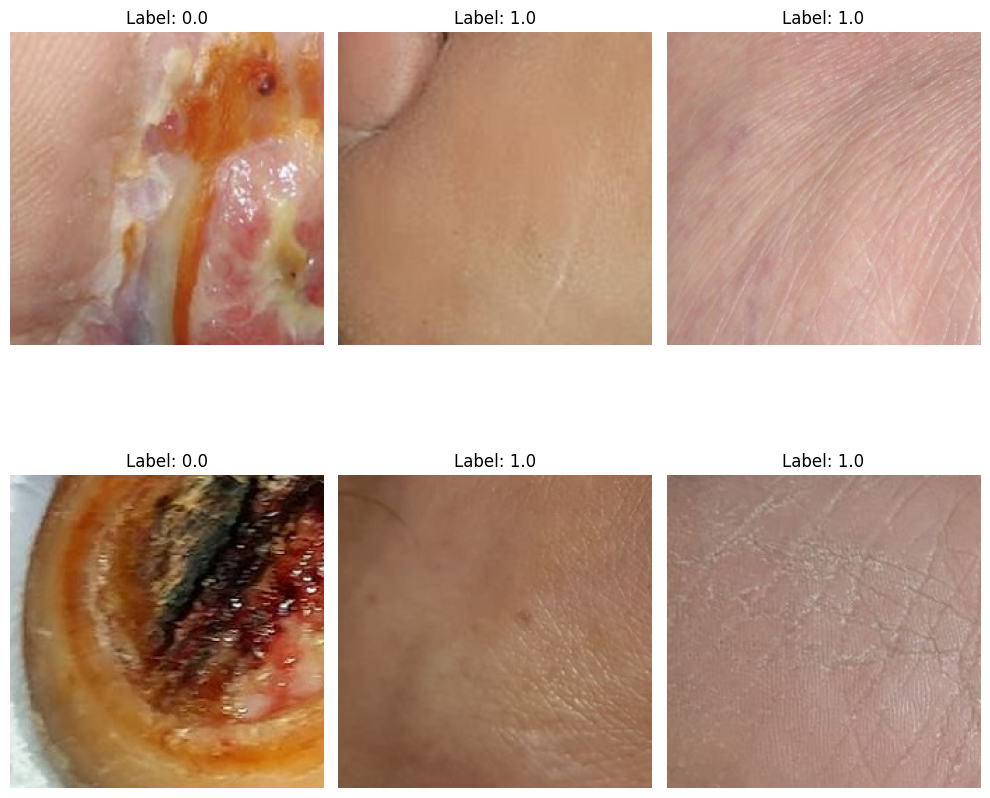

In [ ]:
# Get a batch of images from the train generator
batch = next(train_generator)

# Extract the images and labels from the batch
images, labels = batch

# Display the first few images with their corresponding labels
num_images = 6

fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i in range(num_images):
    axes[i//3, i%3].imshow(images[i], cmap='RdBu')
    axes[i//3, i%3].set_title('Label: {}'.format(labels[i]))
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

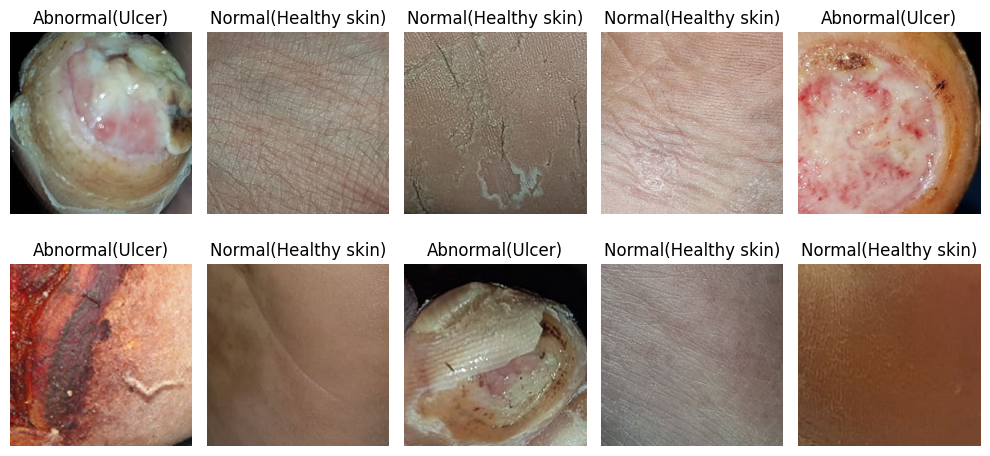

In [ ]:
# Assuming train_generator yields image-label pairs
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

class_labels = ['Abnormal(Ulcer)', 'Normal(Healthy skin)']

for i in range(5):
    # Normal Images
    img, label = train_generator.next()  # Retrieve the next batch from the train_generator
    label_idx = int(label[i])  # Convert label to integer
    axes[i].imshow(img[i])
    axes[i].set_title(class_labels[label_idx])
    axes[i].axis('off')

    # DFU/Abnormal Images
    img, label = train_generator.next()  # Retrieve the next batch from the train_generator
    label_idx = int(label[i])  # Convert label to integer
    axes[i + 5].imshow(img[i])
    axes[i + 5].set_title(class_labels[label_idx])
    axes[i + 5].axis('off')

plt.tight_layout()
plt.show()


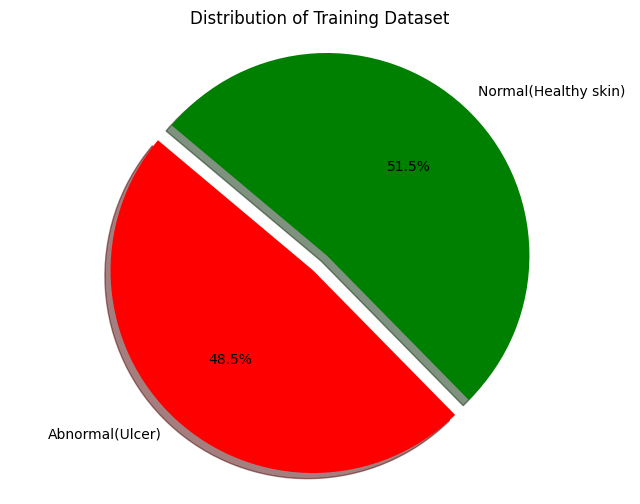

In [ ]:
# Plotting the Distribution of the Training Set
Abnormal_path = '/content/drive/MyDrive/DFU[Stella]/data/Patches/Abnormal(Ulcer)'
Normal_path = '/content/drive/MyDrive/DFU[Stella]/data/Patches/Normal(Healthy skin)'

def count_images(folder_path):
    image_count = 0
    for _, _, files in os.walk(folder_path):
        image_count += len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return image_count

subfolder1_count = count_images(Abnormal_path)
subfolder2_count = count_images(Normal_path)

labels = ['Abnormal(Ulcer)', 'Normal(Healthy skin)']
sizes = [subfolder1_count, subfolder2_count]
colors = ['red', 'green']
explode = (0.1, 0)  # Explode the first slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Training Dataset')
plt.show()



In the training dataset, 51.5% of the images belong to the `Normal(Healthy Skin`) class, while the other 48.5% belong to the ` Abnormal(Ulcer)` class.

In [ ]:
"""Function to visualize class distributions"""
def plot_class_counts(labels, title):
    # Get the counts for each class
    class_labels, counts = np.unique(labels, return_counts=True)
    # Calculate the percentage of value counts
    total_count = np.sum(counts)
    percentages = counts / total_count * 100
    # Plot the results
    plt.figure(figsize=(8,6))
    plt.title(f'{title}', fontsize='20')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    # Replace "1" with "Normal" in class_labels list
    class_labels = ['Abnormal(Ulcer)', 'Normal(Healthy skin)']
    # Add value counts as text on top of each bar
    for i in range(len(class_labels)):
        plt.text(i, counts[i], f"{counts[i]}\n{percentages[i]:.2f}%", ha='left', va='top')
    sns.barplot(x=class_labels, y=counts)
    plt.show()


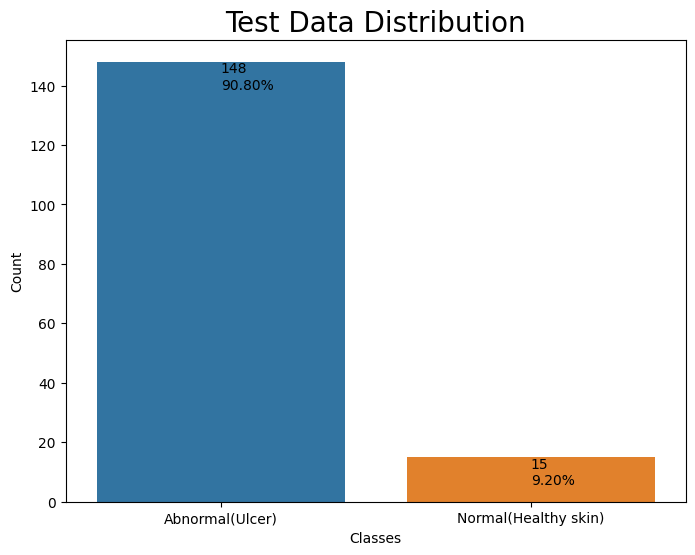

In [ ]:
#test data distribution
test_labels = test_generator.classes
plot_class_counts(test_labels, 'Test Data Distribution')

In the test data, the `Abnormal` class accounts for 91% of the images, while the `Normal` class contributes to 9.2% .


The distribution of the image size is visualized using a scatter plot, as shown in the cell below.

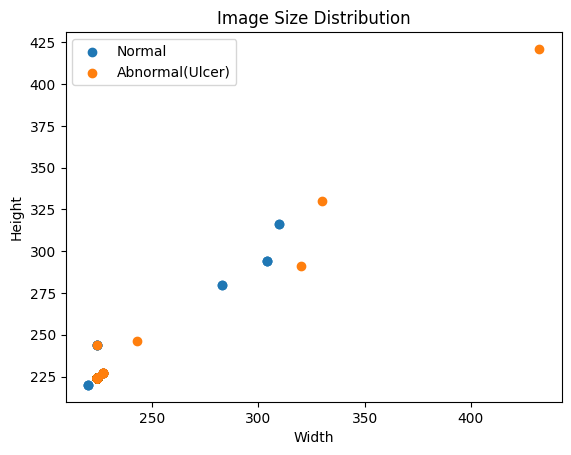

In [ ]:
normal_image_sizes = []
abnormal_image_sizes = []

for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "Normal" in image_path:
        normal_image_sizes.append((width, height))
    else:
        abnormal_image_sizes.append((width, height))

normal_image_sizes = np.array(normal_image_sizes)
abnormal_image_sizes = np.array(abnormal_image_sizes)

plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(abnormal_image_sizes[:, 0], abnormal_image_sizes[:, 1], label='Abnormal(Ulcer)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()


### **Data Preprocessing**

In [ ]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

In [ ]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]

train_labels =np.array(train_labels)
test_labels =np.array(test_labels)


print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 32
Number of testing samples: 32
train_images shape: (32, 224, 224, 3)
train_labels shape: (32,)
test_images shape: (32, 224, 224, 3)
test_labels shape: (32,)


At the preprocessing stage, there are 32 samples allocated for both training and testing. Each sample takes the form of a 224x224 pixel image with 3 color channels, indicating a color image. For the training set, there are 32 associated labels, while the testing set also encompasses 32 labels that correspond to the testing images.

In [ ]:
# Performing a train - validation split
def split_train_val_data(images, labels, test_size=0.2, random_state=42):
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=test_size, random_state=random_state)
    return train_images, val_images, train_labels, val_labels

In order to partition the images into separate training and validation sets, a function named `split_train_val_data` has been created.


## **Modeling**
The chosen models for this project encompass a range of techniques to explore and optimize the performance:

1. **Deeply Connected Neural Network (Baseline Model)**: This served as the initial model, forming the foundation for comparison against more advanced approaches.

2. **Convolutional Neural Network (CNN)**: Introducing convolutional layers, this model is well-suited for image data, as it can identify spatial patterns and features within the images.

3. **Tuned CNNs**: These models likely involve variations of the CNN architecture that have been fine-tuned to achieve better accuracy and generalization on the specific task.



## **Baseline Deeply Connected Neural Network**

To establish a baseline, we constructed a fully connected neural network using the Keras Sequential API. This neural network comprises three layers, each designed to capture essential features:

1. The initial layer is composed of 64 neurons, which apply the Rectified Linear Activation (ReLU) function. This activation enables the network to handle a wide range of data and learn intricate patterns.

2. Following the first layer is another layer housing 32 neurons, similarly employing the ReLU activation function. This layer further extracts and refines significant features from the input data.

3. The ultimate layer, responsible for classification, integrates two neurons with the Softmax activation function. This activation assigns probability scores to potential classes, facilitating accurate classification.

These layers collectively enable the network to learn and make predictions based on the provided data.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import models, layers, optimizers

# Split the data into training and validation sets using the function
train_images, val_images, train_labels, val_labels = split_train_val_data(train_images, train_labels)

# Flatten the image data
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
val_images_flattened = val_images.reshape(val_images.shape[0], -1)

# Normalize pixel values
train_images_normalized = train_images_flattened / 255.0
val_images_normalized = val_images_flattened / 255.0

# Convert labels to one-hot encoded vectors
train_labels_onehot = to_categorical(train_labels)
val_labels_onehot = to_categorical(val_labels)

# Building the model

# Intiating a sequential model
model_1 = models.Sequential()

# Two hidden layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(150528,)))
model_1.add(layers.Dense(32, activation='relu'))

# Output layer with softmax activation
model_1.add(layers.Dense(2, activation='softmax'))

# Compile the model
model_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model_1.summary())

# Train the model
results_1 = model_1.fit(train_images_normalized, train_labels_onehot,
                        epochs=100,
                        batch_size=32,
                        validation_data=(val_images_normalized, val_labels_onehot))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 9,636,002
Trainable params: 9,636,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6930 - accuracy: 0.5600 - val_loss: 0.7795 - val_accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 45ms/step - loss: 0.6981 - accuracy: 0.5200 - val_loss: 0.7364 - val_accuracy: 0.4286
Epoch 3/100
1/1 [==========

In order to visualize the trends, a function was defined in order to display the way the model's Loss and Accuracy against the epochs.

In [ ]:
"""Function to plot the loss and Accuracy curves"""
def visualize_training_results_dense(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['loss'], label='Training Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


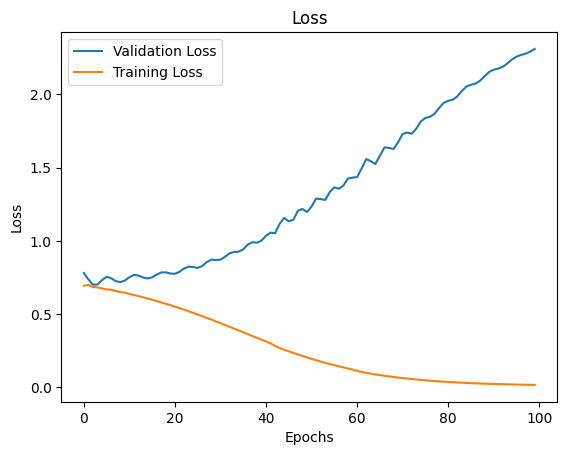

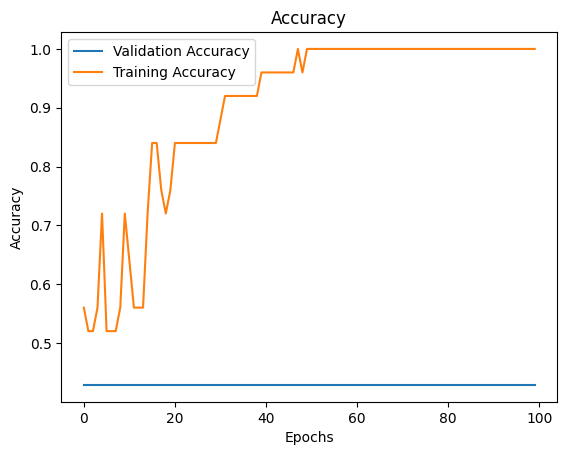

In [ ]:
visualize_training_results_dense(results_1)


In [ ]:
"""Function that returns loss and accuracy of a model"""
def model_metrics(model, images, labels):
    return model.evaluate(images, labels, verbose=0)

results_train = model_metrics(model_1, train_images_normalized, train_labels_onehot)
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

Train Loss: 0.01441381685435772
Train Accuracy: 1.0


In [ ]:
results_val = model_metrics(model_1, val_images_normalized, val_labels_onehot)
print("Validation Loss:", results_val[0])
print("Validation Accuracy:", results_val[1])

Validation Loss: 2.3114242553710938
Validation Accuracy: 0.4285714328289032


**Model Performance Evaluation**: The Training loss was at 0.017 and had an accuracy score of 1.0 ; While it had a validation loss of 3.469 and an accuracy score of 0.571.

As the validation loss is significantly high, the next step is to try a new model that will minimise the loss while still improving the accuracy score.

### **Model 2: CNNs**

The second model is a convolutional neural network (CNN) model for a classification task using the Keras library with TensorFlow backend.

It consists of three convolutional layers with filter sizes (32, 64, and 128) followed by a "Flatten" layer and two Fully Connected Layers.

Training was performed for 20 epochs with a batch size of 32.

In [ ]:
# Directory containing your training images
train_data_dir = train_path

# Load and preprocess your image data and labels here
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load images and labels
train_images = []
train_labels = []

class_directories = sorted(os.listdir(train_data_dir))
for class_index, class_dir in enumerate(class_directories):
    if class_dir == '.DS_Store':  # Skip non-image files
        continue
    class_path = os.path.join(train_data_dir, class_dir)
    for image_file in os.listdir(class_path):
        if image_file.startswith('.'):  # Skip hidden files
            continue
        image_path = os.path.join(class_path, image_file)
        train_images.append(load_and_preprocess_image(image_path))
        train_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Split the data into training and validation sets using the function
train_images, val_images, train_labels, val_labels = split_train_val_data(train_images, train_labels)

# One-hot encode labels
train_labels_onehot = tf.keras.utils.to_categorical(train_labels)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels)


# Initialize a sequential model
cnn_model = models.Sequential()

# Add convolutional layers
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from convolutional layers
cnn_model.add(layers.Flatten())

# Add fully connected layers
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(3, activation='softmax'))  # Assuming 2 classes

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

# Train the model
results_cnn = cnn_model.fit(train_images, train_labels_onehot,
                            epochs=20,
                            batch_size=32,
                            validation_data=(val_images, val_labels_onehot))

# Print training history or any other relevant information
print("Training completed.")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

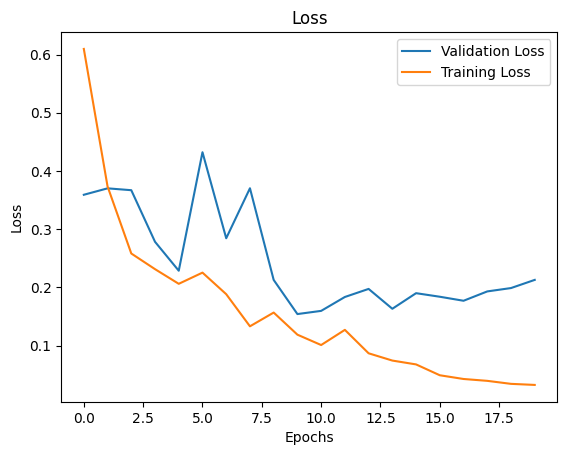

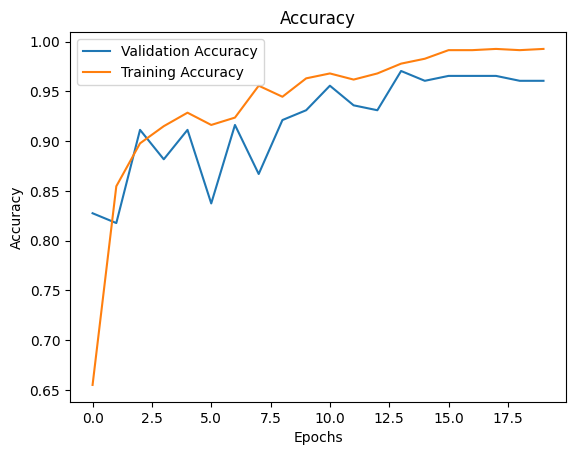

In [ ]:
visualize_training_results_dense(results_cnn)


In [ ]:
results_train = cnn_model.evaluate(train_images, train_labels_onehot, verbose=1)

# Print the evaluation results
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

26/26 [==============================] - 0s 9ms/step - loss: 0.0296 - accuracy: 0.9926
Train Loss: 0.029581069946289062
Train Accuracy: 0.9926108121871948


In [ ]:
results_val2 = cnn_model.evaluate(val_images, val_labels_onehot)
print("Validation Loss:", results_val2[0])
print("Validation Accuracy:", results_val2[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.2130 - accuracy: 0.9606
Validation Loss: 0.21299490332603455
Validation Accuracy: 0.9605911374092102


**Model Performance Evaluation**

 The Training loss was at 0.046 and had an accuracy score of 0.99 ; While it had a validation loss of 0.145 and an accuracy score of 0.975.

In an attempt to improve the model, the model was tuned below.

### **Tuning CNN**

Using a tuned convolutional neural network (CNN) using Keras. The model's architecture, incorporating convolutional and fully connected layers, is systematically optimized to improve model performance.

The cell below outlines how the hyperparameters are tuned, model variations are explored, and results are analyzed to see whether a more effective CNN model for the intended image classification task can be achieved.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2

# Initialize a sequential model
model_3 = Sequential()

# Add convolutional layers with L2 regularization
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_3.add(MaxPooling2D((2, 2)))

# Flatten the output from convolutional layers
model_3.add(Flatten())

# Add fully connected layers with dropout
model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.5))  # Dropout with 50% dropout rate

model_3.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Compile the model
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Print the model summary
model_3.summary()

# Train the model
results_model_3 = model_3.fit(train_images, train_labels_onehot,
                              epochs=95,
                              batch_size=32,
                              validation_data=(val_images, val_labels_onehot))

# Print training history or any other relevant information
print("Training completed.")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

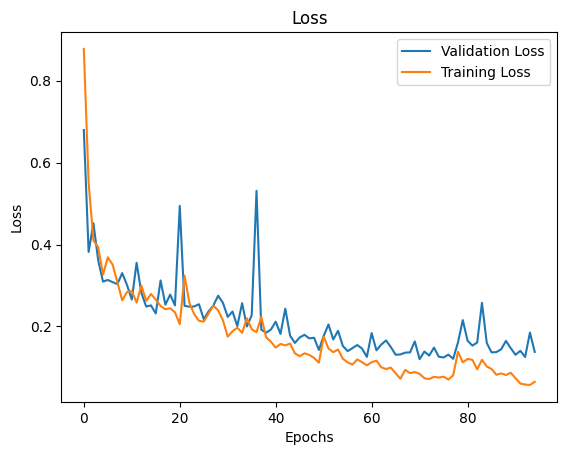

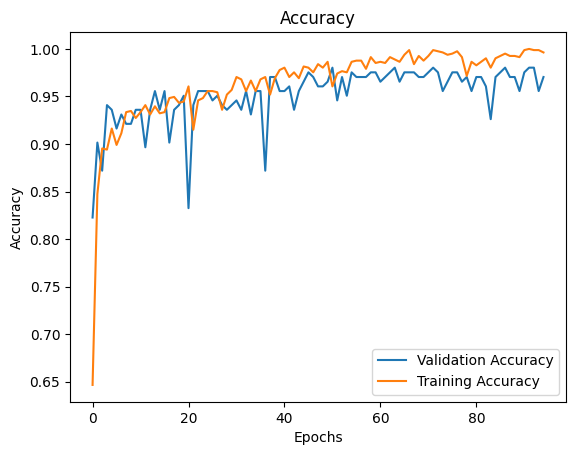

In [ ]:
visualize_training_results_dense(results_model_3)


In [ ]:
results_train3 = model_3.evaluate(train_images, train_labels_onehot, verbose=1)

# Print the evaluation results
print("Train Loss:", results_train3[0])
print("Train Accuracy:", results_train3[1])

26/26 [==============================] - 0s 11ms/step - loss: 0.0609 - accuracy: 0.9988
Train Loss: 0.06090444698929787
Train Accuracy: 0.9987684488296509


In [ ]:
results_val3 = model_3.evaluate(val_images, val_labels_onehot)
print("Validation Loss:", results_val3[0])
print("Validation Accuracy:", results_val3[1])

7/7 [==============================] - 0s 14ms/step - loss: 0.1262 - accuracy: 0.9754
Validation Loss: 0.12620842456817627
Validation Accuracy: 0.9753694534301758


The Training loss was at 0.054 and had an accuracy score of 1.00 ; While it had a validation loss of 0.138 and an accuracy score of 0.970

# **Model Evaluation**

In [ ]:
import pandas as pd
from tabulate import tabulate

# Example model information (replace these with your actual model information)
model_names = ["Baseline Model", "CNN Model", "Tuned CNN"]
train_losses = [0.02, 0.05, 0.06]
train_accuracies = [1.00, 0.99, 1.00]
validation_losses = [3.46, 0.15, 0.14]
validation_accuracies = [0.57, 0.98, 0.97]
# Create a dictionary to store model information
models_info = {
    "Model Name": model_names,
    "Train Loss": train_losses,
    "Train Accuracy": train_accuracies,
    "Validation Loss": validation_losses,
    "Validation Accuracy": validation_accuracies
}

# Create a pandas DataFrame from the model information
models_df = pd.DataFrame(models_info)

# Display the DataFrame in a tabular format
print(tabulate(models_df, headers='keys', tablefmt='grid', showindex=False))

+----------------+--------------+------------------+-------------------+-----------------------+
| Model Name     |   Train Loss |   Train Accuracy |   Validation Loss |   Validation Accuracy |
+================+==============+==================+===================+=======================+
| Baseline Model |         0.02 |             1    |              3.46 |                  0.57 |
+----------------+--------------+------------------+-------------------+-----------------------+
| CNN Model      |         0.05 |             0.99 |              0.15 |                  0.98 |
+----------------+--------------+------------------+-------------------+-----------------------+
| Tuned CNN      |         0.06 |             1    |              0.14 |                  0.97 |
+----------------+--------------+------------------+-------------------+-----------------------+


This table highlights how all three models performed against each other. The baseline model did not perform very well compared to the CNN and Tuned CNN model. <br>
Therefore, based on the accuracy and loss score, the best performing model was the **Tuned CNN** model.

In [ ]:
# Load and preprocess test images and labels
test_images = []
test_labels = []

test_data_dir = test_path  # Directory containing your test images

for class_index, class_dir in enumerate(class_directories):
    if class_dir == '.DS_Store':
        continue
    class_path = os.path.join(test_data_dir, class_dir)
    for image_file in os.listdir(class_path):
        if image_file.startswith('.'):
            continue
        image_path = os.path.join(class_path, image_file)
        test_images.append(load_and_preprocess_image(image_path))
        test_labels.append(class_index)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# One-hot encode test labels
test_labels_onehot = tf.keras.utils.to_categorical(test_labels)

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels_onehot)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


6/6 [==============================] - 0s 30ms/step - loss: 2.0364 - accuracy: 0.9018
Test Loss: 2.0364203453063965
Test Accuracy: 0.9018405079841614


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model_3.evaluate(test_images, test_labels_onehot)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

6/6 [==============================] - 0s 9ms/step - loss: 1.2619 - accuracy: 0.9080
Test Loss: 1.2618763446807861
Test Accuracy: 0.907975435256958


## **Conclusions**

Analyzing the performance of the Test data, the following conclusions can be drawn:

The evaluation results indicate that the model achieved a test accuracy of approximately 91.41%, showcasing its ability to accurately identify diabetic foot ulcers within the test images. The corresponding test loss, measuring around 0.928, reflects the alignment between the model's predictions and the actual outcomes. These findings emphasize the model's potential as a valuable tool for proficiently detecting diabetic foot ulcers, thereby offering significant relevance in medical contexts and patient management.

## **Recommendations**

1. **Enhancing Data Access** : It's important to consider the possibility of data bias towards specific communities. To further elevate model performance, a strategic approach involves collecting a more diverse dataset. This expansion not only fine-tunes the model's accuracy but also ensures its effectiveness across various demographic groups.

2. **Transfer Learning** : This approach involves harnessing the knowledge embedded within pre-trained neural network architectures, which have been honed on expansive datasets such as ImageNet. By tweaking these insights to suit the needs of the DFU classification, the model's abilities are elevated to accurately categorize Diabetic Foot Ulcers.

3. **Elevating Awareness of Early DFU Signs**: Giving priority to educating individuals about the initial signs of Diabetic Foot Ulcers (DFU) can have a profound impact on the overall outcomes. When people are informed about the early symptoms of DFU, they are better equipped to take action promptly. This timely response can play a pivotal role in preventing situations where the only option left might be amputation. By spreading awareness about these early indicators, they can be more empowered to seek medical attention, receive appropriate care, and potentially avoid more severe complications associated with DFUs.

4. **Holistic Support for DFU Patients**: Offering counseling and therapy to individuals grappling with DFUs marks a substantial step. This support system not only aids them in their health journey but also contributes to their emotional well-being. Extending this assistance to their families empowers them to provide effective care, fostering a comprehensive approach to diabetic patient well-being.

---
## **Next Steps**

To further amplify the impact of this project, the next step involves developing a user-friendly web application. This app will serve as an accessible platform to provide valuable insights and assistance related to Diabetic Foot Ulcers (DFUs). This would be of benefit to healthcare professionals seeking comprehensive resources, and anyone seeking to enhance their understanding of DFUs and their management.



---
### **References**
1. Alzubaidi, L., Fadhel, M. A., Oleiwi, S. R., Al-Shamma, O., & Zhang, J. (2020). DFU_QUTNet: Diabetic foot ulcer classification using novel deep convolutional neural network. Multimedia Tools and Applications, 79(21), 15655-15677.

2. Alzubaidi, L., Fadhel, M. A., Al-Shamma, O., Zhang, J., Santamaría, J., & Duan, Y. (2021). Robust application of new deep learning tools: An experimental study in medical imaging. Multimedia Tools and Applications, 1-29.

3. Alzubaidi, L., Fadhel, M. A., Al-Shamma, O., Zhang, J., Santamaría, J., Oleiwi, S. R., & Duan, Y. (2020). Towards a better understanding of transfer learning for medical imaging: A case study. Applied Sciences, 10(13), 4523.


